In [10]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

import numpy as np
import math
import random
from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

from torch.ao.quantization.quantize_pt2e import (
  prepare_pt2e,
  convert_pt2e,
)
from torch._export import capture_pre_autograd_graph
from torch.ao.quantization.quantizer.xnnpack_quantizer import (
    XNNPACKQuantizer,
    get_symmetric_quantization_config,
)

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'results/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny. PTQ Quant One Head. Pytorch 2 Export Quantization.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] / 255.0
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

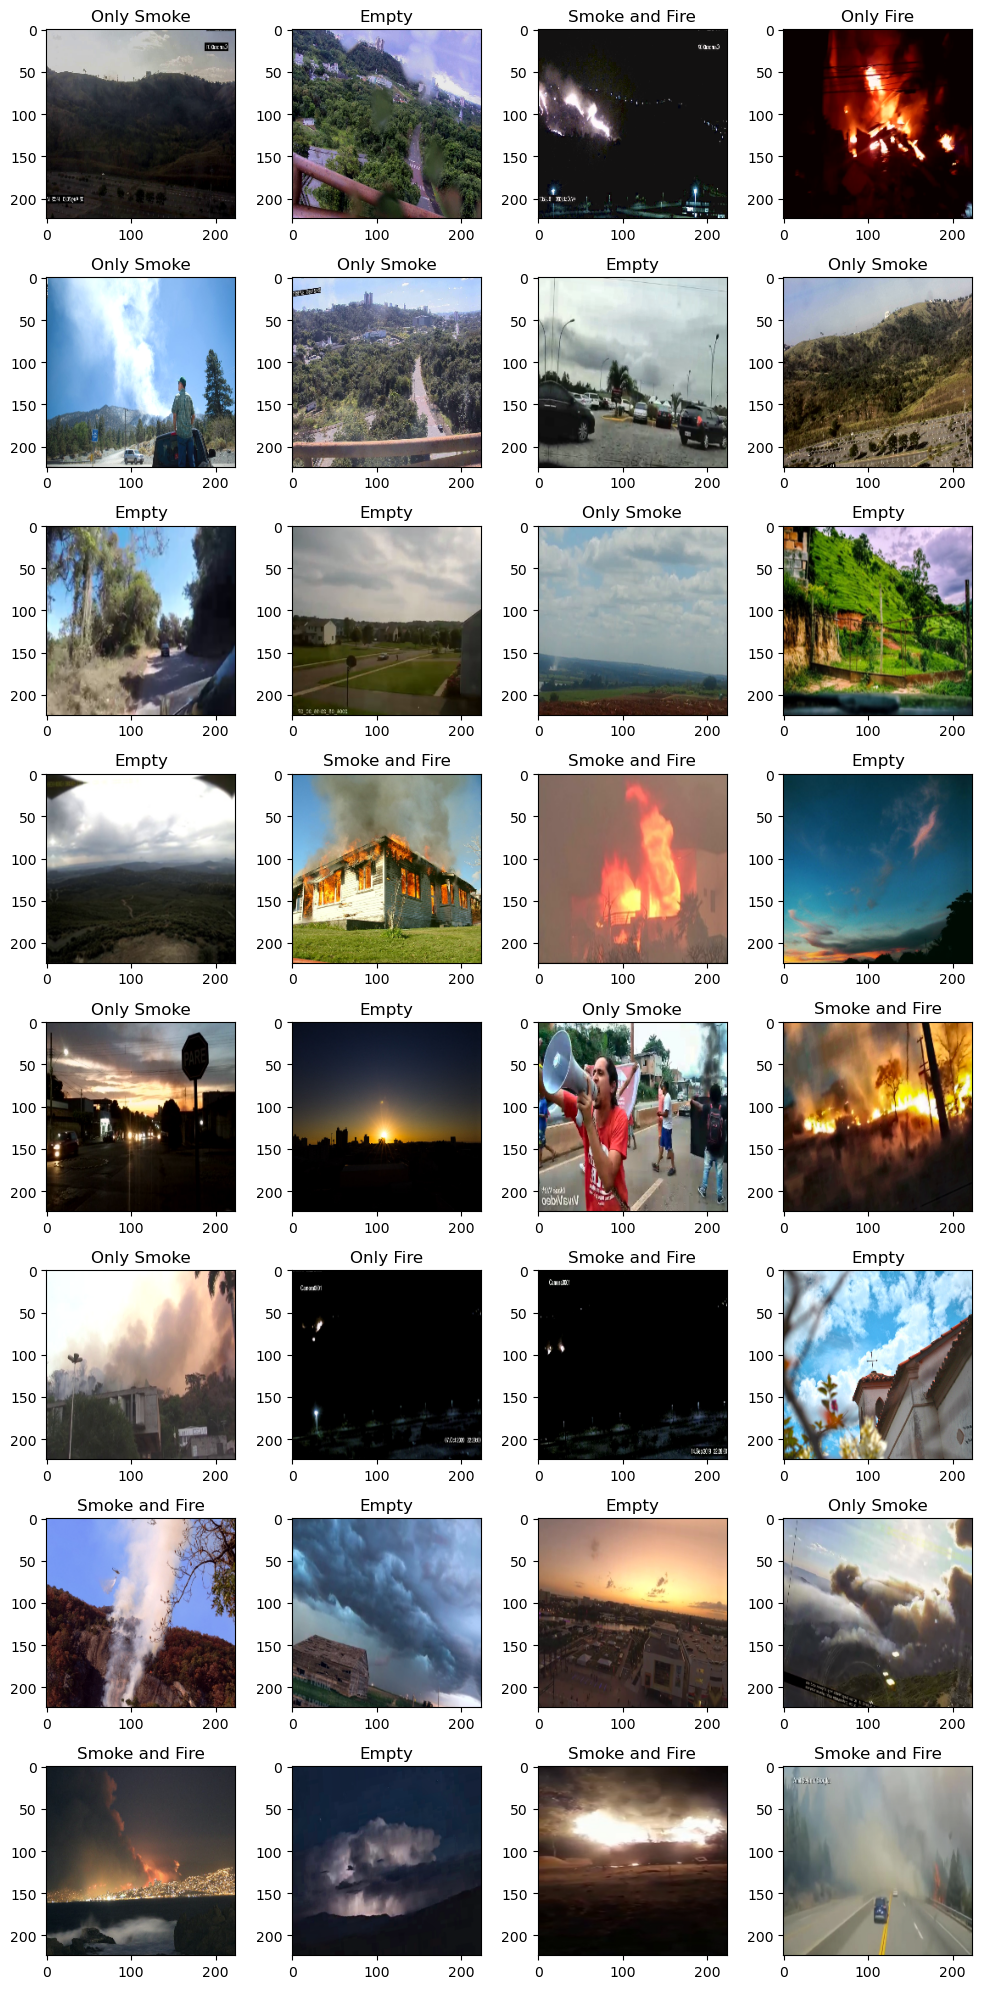

In [11]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Hyperparameters

In [12]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"

#DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"
BATCH_SIZE = 64 
NUM_WORKERS = 8
PIN_MEMORY = True
LOAD_MODEL = True
if MODEL == "BED":
    LOAD_MODEL_FILE = "../../best_smoke_BED_classifier.pt"

VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

DS_LEN = 512

# Metrics

In [13]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Dataset Setup

In [14]:
# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 241
DFire only smoke images: 141
DFire only fire images: 30
DFire smoke and fire images: 100
Test dataset len: 512


# Model: BED Less Layers

In [15]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 64
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(16, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(self.last_channels, affine=False),
            nn.ReLU(),

            # Output One Head, 2 Neurons
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(start_dim=1),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=2),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        return x

# Model Setup

In [16]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE) 
    model.eval()
    quant_model = BED_CLASSIFIER(num_classes=N_CLASSES).to('cpu')
    quant_model.eval()
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[-0.0955,  0.1958],
        [-0.0955,  0.1958],
        [-0.0955,  0.1958],
        [-0.0955,  0.1958]], grad_fn=<AddmmBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affin

# Load Weights

In [17]:
if LOAD_MODEL == False:
    print("Weights must be loaded before Quantization")
    logger.info("Weights must be loaded before Quantization")
    raise SystemExit("Weights must be loaded before Quantization")
else:
    checkpoint = torch.load(LOAD_MODEL_FILE)
    model.load_state_dict(checkpoint['model_state_dict'])
    checkpoint_quant = torch.load(LOAD_MODEL_FILE, map_location=torch.device('cpu'))
    quant_model.load_state_dict(checkpoint_quant['model_state_dict'])
    print(f"Loading Model")
    logger.info(f"Loading Model")

Loading Model


# Quantization PTQ

### Calibration function

In [18]:
# define calibration function
def calibrate(model, data_loader):
    #model.eval()
    with torch.no_grad():
        for image, target in data_loader:
            model(image)

### Get one input from Val Loader

In [17]:
for img, label in val_loader:
    global ex_in 
    ex_in = img[29:30].to('cpu')
    print(ex_in.shape)
    break

torch.Size([1, 3, 224, 224])


In [19]:
#example_inputs = (ex_in,)
example_inputs = (next(iter(val_loader))[0],)

In [20]:
# Step 1. program capture
# NOTE: this API will be updated to torch.export API in the future, but the captured
# result should mostly stay the same
m = capture_pre_autograd_graph(quant_model, example_inputs)
# we get a model with aten ops

In [21]:
# Step 2. quantization
# backend developer will write their own Quantizer and expose methods to allow
# users to express how they
# want the model to be quantized
quantizer = XNNPACKQuantizer().set_global(get_symmetric_quantization_config())
m = prepare_pt2e(m, quantizer)

In [22]:
calibrate(m, val_loader)
quant_model = convert_pt2e(m)

# Evaluate Metrics

In [23]:
def eval_all_metrics(model, loader):
               
    loop = tqdm(loader, desc='Validating', leave=True)

    for image, label in loop:
        output = model(image)
        precision_metric.update(output, label)
        recall_metric.update(output, label)
        accuracy_metric.update(output, label)
        f1_metric.update(output, label)

    pre_res = precision_metric.compute()
    rec_res = recall_metric.compute()
    acc_res = accuracy_metric.compute()
    f1_res = f1_metric.compute()

    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
        
    return {
        'Accuracy': acc_res,
        'Precision': pre_res,
        'Recall': rec_res,
        'F1-score': f1_res
    }   

In [24]:
all_metrics = eval_all_metrics(quant_model, val_loader)

Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.99s/it]


In [25]:
metrics_data = np.zeros((2, 4))
for i, (k, v) in enumerate(all_metrics.items()):
    metrics_data[0, i] = np.round(100*v[0].item(), decimals=2)
    metrics_data[1, i] = np.round(100*v[1].item(), decimals=2)
metrics_data

array([[90.62, 92.14, 87.55, 89.79],
       [94.73, 95.58, 83.08, 88.89]])

In [26]:
index = ['Smoke', 'Fire']
cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
df1 = pd.DataFrame(metrics_data, index = index, columns = cols)
df1

,Accuracy,Precision,Recall,F1-Score
Smoke,90.62,92.14,87.55,89.79
Fire,94.73,95.58,83.08,88.89


# Save the Model

In [27]:
ref = quant_model(*example_inputs)

In [39]:
pt2e_quantized_model_file_path = './quant_pytorch_PTQ.pth'
pt2e_quantized_model_file_path_2 = './quant_pytorch_PTQ.pt'
quantized_ep = torch.export.export(quant_model, example_inputs)
torch.export.save(quantized_ep, pt2e_quantized_model_file_path)
torch.export.save(quantized_ep, pt2e_quantized_model_file_path_2)

# Load Model and Check Metrics Again

In [29]:
loaded_quantized_ep = torch.export.load(pt2e_quantized_model_file_path)
loaded_quantized_model = loaded_quantized_ep.module()

In [30]:
res = loaded_quantized_model(*example_inputs)

In [31]:
print("Difference after serialization/deserialization", ref[:10]-res[:10])

Difference after serialization/deserialization tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


### Metrics: evaluate Model after loading -> Serialization + Deserialization

In [32]:
q_metrics = eval_all_metrics(loaded_quantized_model, val_loader)

Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.44s/it]


In [33]:
q_metrics_data = np.zeros((2, 4))
for i, (k, v) in enumerate(q_metrics.items()):
    q_metrics_data[0, i] = np.round(100*v[0].item(), decimals=2)
    q_metrics_data[1, i] = np.round(100*v[1].item(), decimals=2)
q_metrics_data

array([[90.62, 92.14, 87.55, 89.79],
       [94.73, 95.58, 83.08, 88.89]])

In [34]:
index = ['Smoke', 'Fire']
cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
df2 = pd.DataFrame(q_metrics_data, index = index, columns = cols)
df2

,Accuracy,Precision,Recall,F1-Score
Smoke,90.62,92.14,87.55,89.79
Fire,94.73,95.58,83.08,88.89


In [35]:
df1

,Accuracy,Precision,Recall,F1-Score
Smoke,90.62,92.14,87.55,89.79
Fire,94.73,95.58,83.08,88.89


# Explore torch.export

In [35]:
#print(quantized_ep.graph_module)
#print(quantized_ep.graph_signature)

In [36]:
#compiled_model = torch.compile(quantized_ep)

In [37]:
#print(compiled_model)

# Export to Onnx

In [37]:
# torch.onnx.export(loaded_quantized_model,    # model being run
#                   example_inputs,            # model input (or a tuple for multiple inputs)
#                   "quant_pytorch_PTQ.onnx",  # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=10,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['input'],   # the model's input names
#                   output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}})
# int8_onnx_config = Torch2ONNXConfig(
#     dtype="int8",
#     opset_version=14,
#     quant_format="QOperator",  # or QDQ
#     example_inputs=img.unsqueeze(dim=0), #torch.randn(1, 3, 224, 224),
#     input_names=["input"],
#     output_names=["output"],
#     dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
# )

# q_model.export("int8-model.onnx", int8_onnx_config)
# onnx_program = torch.onnx.dynamo_export(loaded_quantized_model, example_inputs)

# Print the Model

In [38]:
print(loaded_quantized_model)

GraphModule()



def forward(self, arg_0):
    arg28_1, = fx_pytree.tree_flatten_spec(([arg_0], {}), self._in_spec)
    model_0_weight_bias = self.model_0_weight_bias
    model_5_weight_bias = self.model_5_weight_bias
    model_10_weight_bias = self.model_10_weight_bias
    model_13_weight_bias = self.model_13_weight_bias
    model_16_weight_bias = self.model_16_weight_bias
    model_19_weight_bias = self.model_19_weight_bias
    model_23_weight_bias = self.model_23_weight_bias
    model_26_weight_bias = self.model_26_weight_bias
    model_29_weight_bias = self.model_29_weight_bias
    model_32_weight_bias = self.model_32_weight_bias
    model_35_weight_bias = self.model_35_weight_bias
    model_38_weight_bias = self.model_38_weight_bias
    model_44_bias = self.model_44_bias
    model_46_bias = self.model_46_bias
    _frozen_param0 = self._frozen_param0
    _frozen_param1 = self._frozen_param1
    _frozen_param2 = self._frozen_param2
    _frozen_param3 = self._frozen_param3
    _froze

# Print Model

In [ ]:
print(int8_model)

In [ ]:
int8_model(ex_in)

In [ ]:
print(int8_model.print_readable())

In [ ]:
#torch.onnx.export(ptq_model, in_onnx, "ptq_bed.onnx.pb")

In [ ]:
#ptq_model(in_onnx)

In [ ]:
# plt.imshow(in_onnx[0].permute(1, 2, 0).cpu().numpy())